In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import os
from collections import namedtuple
sys.path.append('C:\\Users\\philip.remes\\OneDrive - Thermo Fisher Scientific\\Documents\\Software\\Jupyter\\PythonUtilities\\')
import utilities_pmr as pmr
COLORS = pmr.setup_environment()
from matplotlib_venn import venn2

In [63]:
Entry = namedtuple('Entry', [
    'peptide', 'replicate', 'protein', 'batch', 'condition', 'mz', 'z', 'rt', 'area',
])

def change_entry_area(entry, area):
    return Entry(entry.peptide, entry.replicate, entry.protein, entry.batch, entry.condition, entry.mz, entry.z, entry.rt, area)

def load_file(file_name):
    df = pd.read_csv(file_name)  
    items = []
    for _,row in df.iterrows():
        rep = re.search('([a-zA-Z\d]+)_[a-zA-Z\d]+$', row['Replicate Name']).group(1)
        # standardize the replicates to a two digit format that the tribrid used
        letters = re.search('([a-zA-Z]+)[\d]+', rep).group(1)
        numbers = int(re.search('[a-zA-Z]+([\d]+)', rep).group(1))
        rep = f'{letters}{numbers}'
        items.append(Entry(
            row['Peptide Modified Sequence'],
            rep,
            row['Protein'],
            row['Batch'],
            row['Condition'],
            row['Precursor Mz'],
            row['Precursor Charge'],
            row['Best Retention Time'],
            0.0 if np.isnan(row['Total Area']) else row['Total Area'],
        ))  
    return items

def organize_data_in_conditions(data):
    '''
        put the data into a dictionary by the a certain condition
    '''
    condition_dict = {}
    for item in data:
        if item.condition not in condition_dict:
            condition_dict[item.condition] = []
        condition_dict[item.condition].append(item)
    return condition_dict

def organize_data_by_replicate(data):
    rep_dict = {}
    for item in data:
        if item.replicate not in rep_dict:
            rep_dict[item.replicate] = []
        rep_dict[item.replicate].append(item)
    return rep_dict    

files = [
    '230315_thorium_peptide_areas.csv',
    '230315_tribrid_peptide_areas.csv',
]

raw_data = [load_file(f) for f in files]

In [66]:
def norm_func_median(raw_data):
    return np.median([x.area for x in raw_data])
    
def norm_func_sum(raw_data):
    return max(1.0, np.sum([x.area for x in raw_data]))

def norm_func_prtc(raw_data):
    total = 0.0
    for item in raw_data:
        if item.protein == 'PRTC':
            total += item.area
    return max(1.0, total)  
    
def normalize_data(raw_data, norm_func, global_norm_func=None):
    '''
        Normalize all the entry areas
        Set the norm for the data equal to the global norm
        Ex.
        If norm(data) = G
        and the norm for each replicate's data is ni,
        Then we want each replicate's norm to equal the global norm.
        Use G = si*ni
        si = G / ni
        So multiply the data by G/ni, ie the global_norm / replicate_norm.
    '''
    # create dict by replicate
    by_rep = organize_data_by_replicate(raw_data)
    global_norm = norm_func(raw_data) if not global_norm_func else global_norm_func(raw_data)
    norms = {rep: norm_func(x) for rep,x in by_rep.items()}
    normed_data = []
    for rep,data_for_rep in by_rep.items():
        norm = norms[rep]
        normed_data.extend([change_entry_area(x, x.area * global_norm / norm) for x in data_for_rep])    
    return normed_data       
    
def normalize_data_median(raw_data):
    return normalize_data(raw_data, norm_func_median)

def normalize_data_sum(raw_data):
    return normalize_data(raw_data, norm_func_sum)
    
def normalize_by_prtc(raw_data):
    return normalize_data(raw_data, norm_func_prtc, lambda x: 1.0)


In [67]:
data_med_norm = [normalize_data_median(d) for d in raw_data]

In [83]:
def get_pep_name(entry):
    return f'{entry.peptide}_{entry.z}'

def organize_by_peptide(data):
    pep_dict = {}
    for item in data:
        name = get_pep_name(item)
        if not name in pep_dict:
            pep_dict[name] = []
        pep_dict[name].append(item)
    return pep_dict

def compute_stats_for_pep(data):
    pep_dict = organize_by_peptide(data)
    stats_by_pep = {}
    for pep,data in pep_dict.items():
        areas = [x.area for x in data]
        stats_by_pep[pep] = {
            'mean': np.mean(areas),
            'std': max(1.0, np.std(areas))
        }
    return stats_by_pep

def compute_zscore_areas(data):
    stats_by_pep = compute_stats_for_pep(data)
    zscored = []
    for item in data:
        stats = stats_by_pep[get_pep_name(item)]
        zscore = (item.area - stats['mean']) / stats['std']
        zscored.append(change_entry_area(item, zscore))
    return zscored

zscored_data = [compute_zscore_areas(d) for d in raw_data]  

In [113]:
def get_identifier(entry):
    return f'{entry.peptide}_{entry.z}_{entry.protein}_{entry.replicate}'

def get_pep_z_prot_id(entry):
    return f'{entry.peptide}_{entry.z}_{entry.protein}'

def organize_by_identifier(data, id_func=get_identifier):
    data_by_id = {}
    for item in data:
        name = id_func(item)
        if not name in data_by_id:
            data_by_id[name] = []
        data_by_id[name].append(item)
    return data_by_id

def average_data_over_ids(data, id_func=get_identifier):
    data_by_id = organize_by_identifier(data, id_func)
    avg_by_id = {}
    for name,data in data_by_id.items():
        mean = np.mean([x.area for x in data])
        avg_by_id[name] = change_entry_area(data[0], mean)
    return avg_by_id

In [184]:
def get_common_peptides(data1, data2):
    peps1 = set([get_pep_name(x) for x in data1])
    peps2 = set([get_pep_name(x) for x in data2])
    return peps1.intersection(peps2)

def get_common_ids(by_id1, by_id2):
    ids1,ids2 = set(by_id1.keys()), set(by_id2.keys())
    return ids1.intersection(ids2)

def get_data_for_cps(data):
    only_cps = {}
    for item in data:
        if 'CP' in item.replicate:
            if not item.replicate in only_cps:
                only_cps[item.replicate] = []
            only_cps[item.replicate].append(item)
    return only_cps

def get_data_for_intersect(by_id, ids):
    extracted = []
    for name in ids:
        extracted.append(by_id[name].area)
    return extracted

common_peps = get_common_peptides(*raw_data)
len(common_peps)

639

Text(0.5, 1.0, 'Correlation Between OT and IT Z-Scored Areas by Peptide')

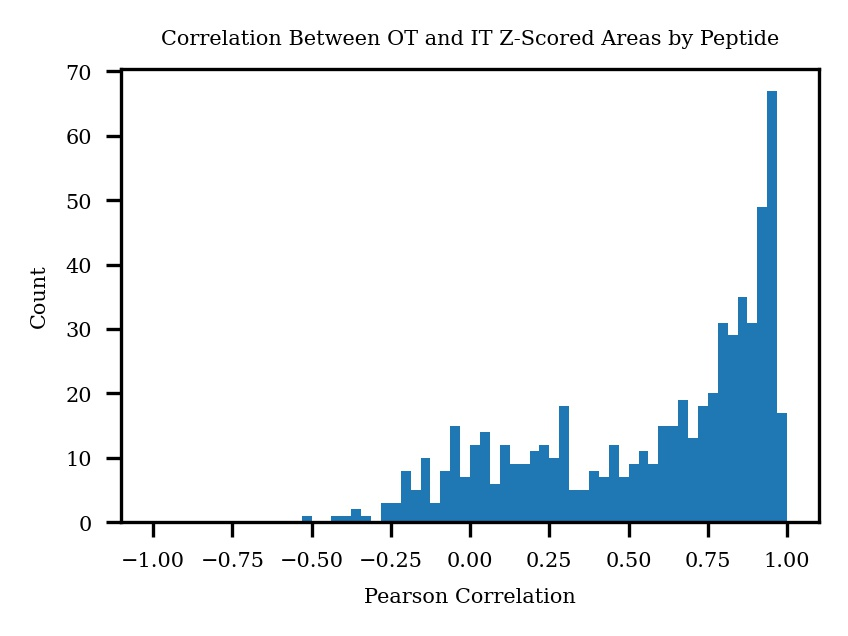

In [192]:
def get_coerrelations(common_peps, data1, data2):
    peps1,peps2 = organize_by_peptide(data1), organize_by_peptide(data2)
    corrs = []
    for pep in common_peps:
        data1,data2 = peps1[pep],peps2[pep]
        avg1,avg2 = average_data_over_ids(data1), average_data_over_ids(data2)
        common_ids = get_common_ids(avg1, avg2)
        areas1,areas2 = get_data_for_intersect(avg1, common_ids), get_data_for_intersect(avg2, common_ids)
        if len(areas1) > 0 and len(areas2) > 0:
            r = np.corrcoef(areas1, areas2)[0, 1]
            corrs.append(r)
    return corrs
        
corrs = get_coerrelations(common_peps, *zscored_data)

fig,ax = plt.subplots()
ax.hist(corrs, 64, range=[-1, 1]);
ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('Count')
ax.set_title('Correlation Between OT and IT Z-Scored Areas by Peptide')

In [193]:
data_for_cps = [get_data_for_cps(d) for d in raw_data]
cp_names = ['CP1', 'CP2', 'CP3', 'CP4']

def plot_cp_data(cp_data, title, color):
    
    fig,axes = plt.subplots(4, 4, figsize=(8, 6))
    fig.suptitle(title, y=0.92)
    for idx in range(16):
        ridx,cidx = idx // 4, idx % 4
        ax = axes[ridx, cidx]
        
        # the data for the two cps
        cp_first = cp_data[cp_names[ridx]]
        cp_second = cp_data[cp_names[cidx]]
        # get the data by id
        first_ids = average_data_over_ids(cp_first, get_pep_z_prot_id)
        second_ids = average_data_over_ids(cp_second, get_pep_z_prot_id)

        ids1,ids2 = set(first_ids.keys()), set(second_ids.keys())
        intersect_ids = ids1.intersection(ids2)
        first_data = get_data_for_intersect(first_ids, intersect_ids)
        second_data = get_data_for_intersect(second_ids, intersect_ids)
        if ridx > cidx:            
            ax.scatter(first_data, second_data, s=1, c=color)
            ax.set_xscale('log')
            ax.set_yscale('log')
            if ridx == 3:
                ax.set_xlabel(f'Intensity {cp_names[cidx]}')
            if cidx == 0:
                ax.set_ylabel(f'Intensity {cp_names[ridx]}')
        elif ridx < cidx:
            r = np.corrcoef(first_data, second_data)[0, 1]
            ax.annotate(f'r={r:.3f}', (0.5, 0.5))
        else:
            min_d,max_d = max(1e3, np.min(first_data)), np.max(first_data)
            ax.hist(first_data, bins=pmr.geom_spaced_series(min_d, max_d, 64), color=color)
            ax.set_xscale('log')
            if ridx == 3:
                ax.set_xlabel('Intensity')
            if cidx == 0:
                ax.set_ylabel('Counts')
            

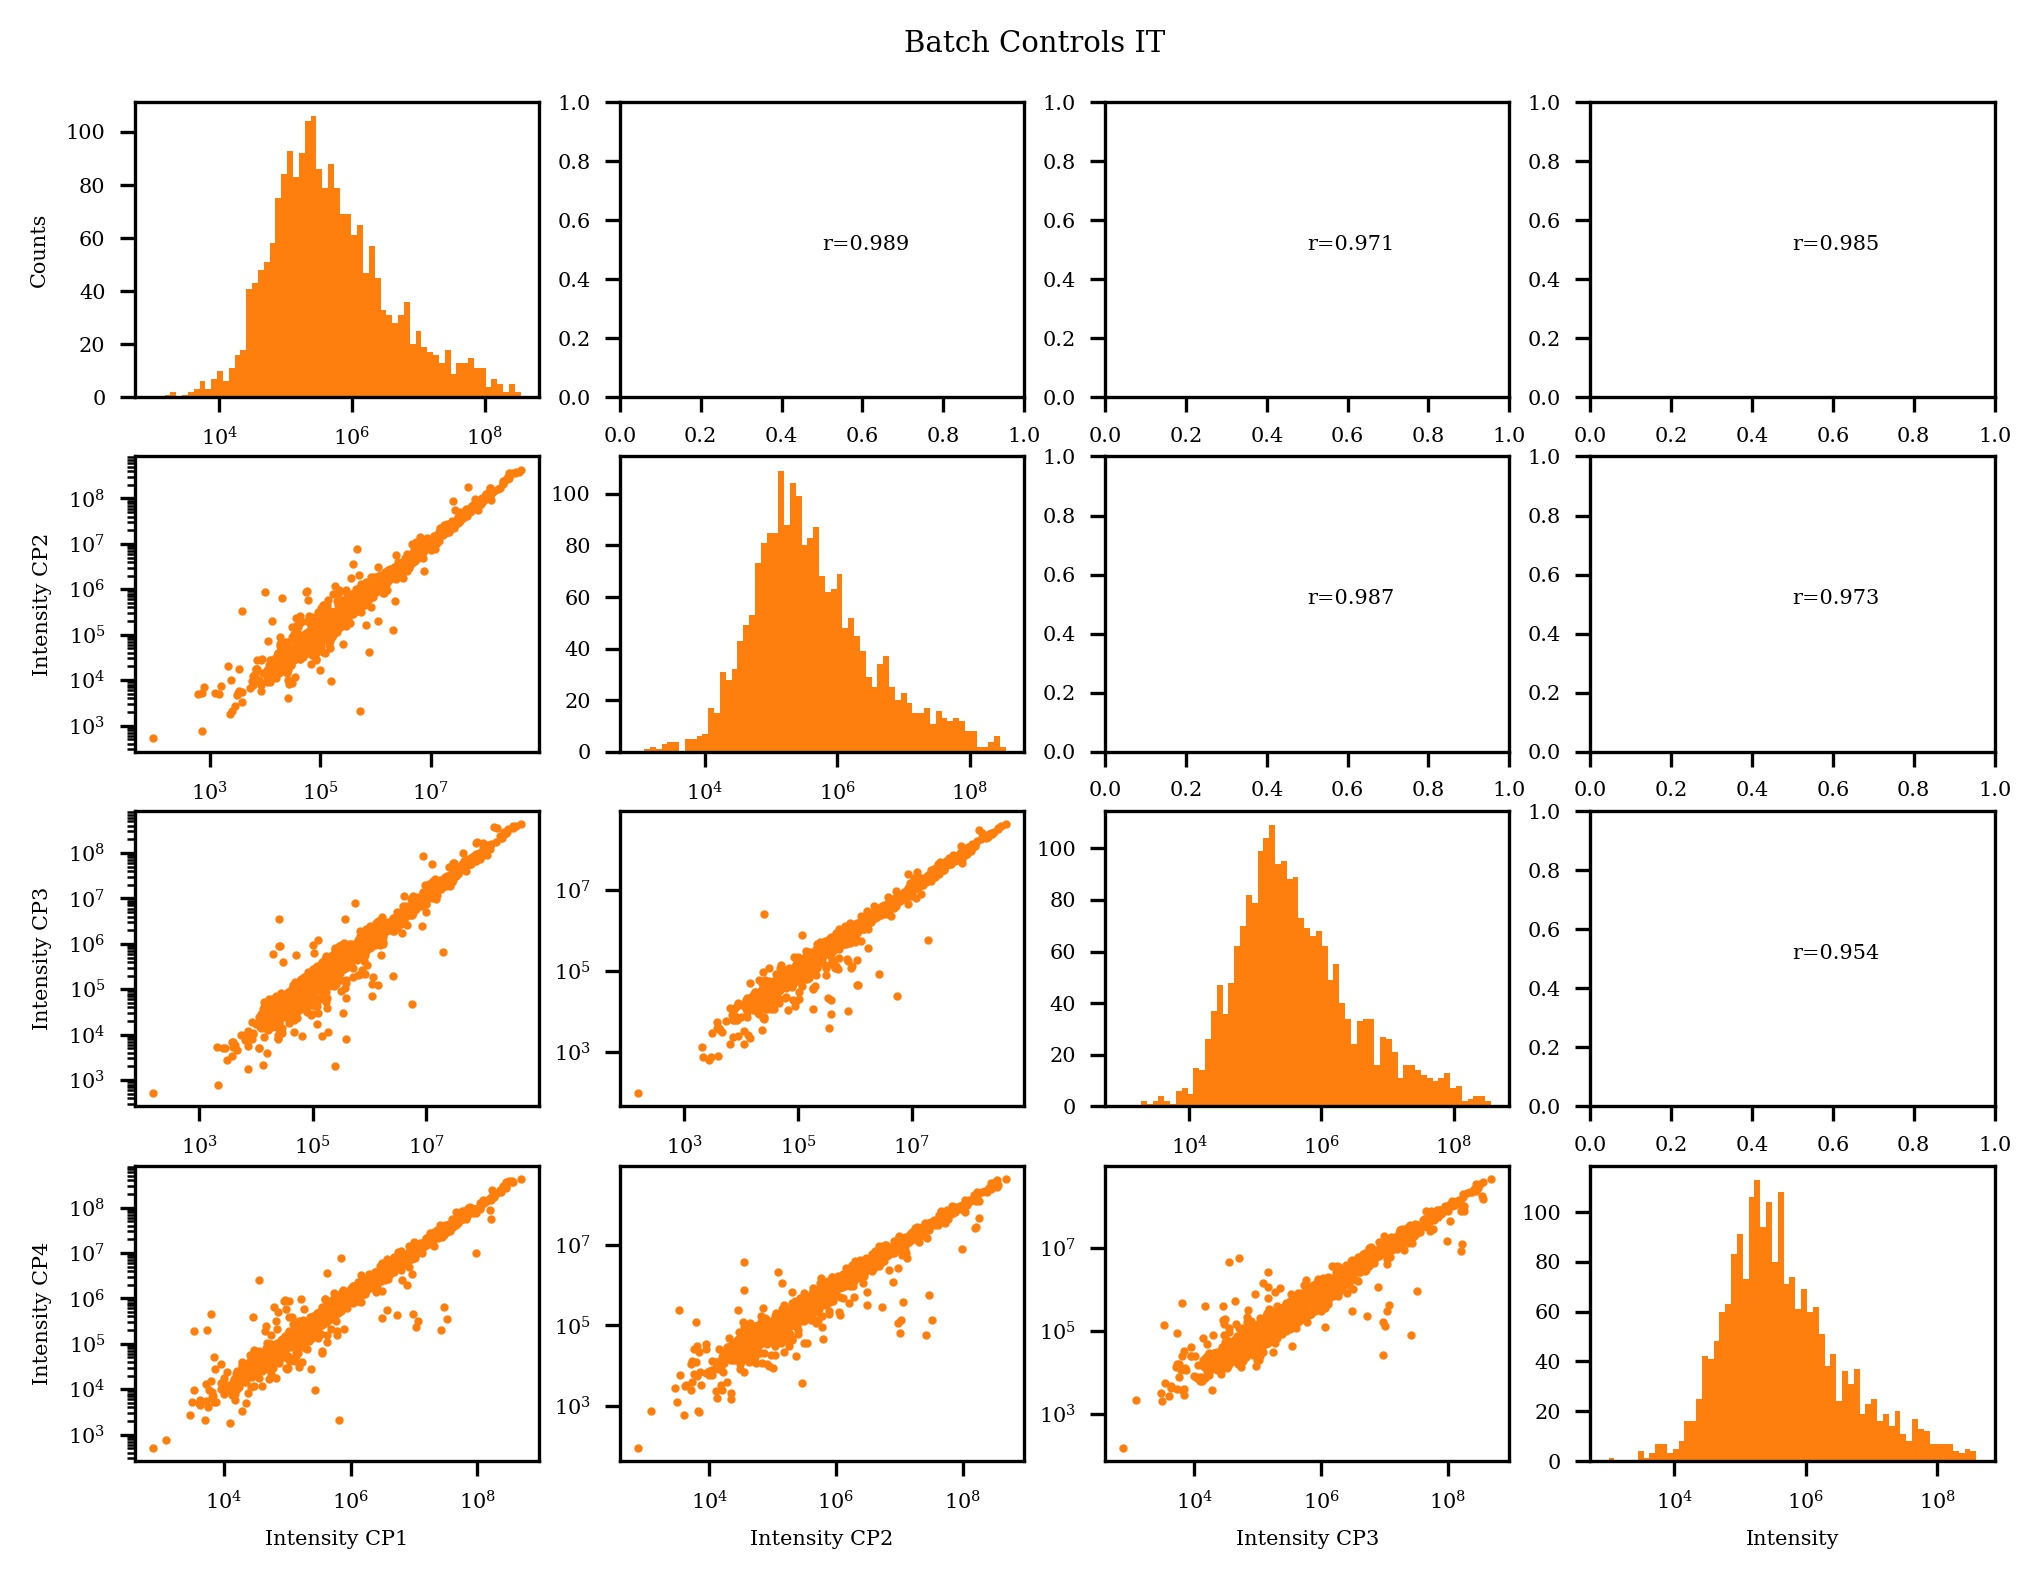

In [194]:
plot_cp_data(data_for_cps[0], title='Batch Controls IT', color=COLORS[1])

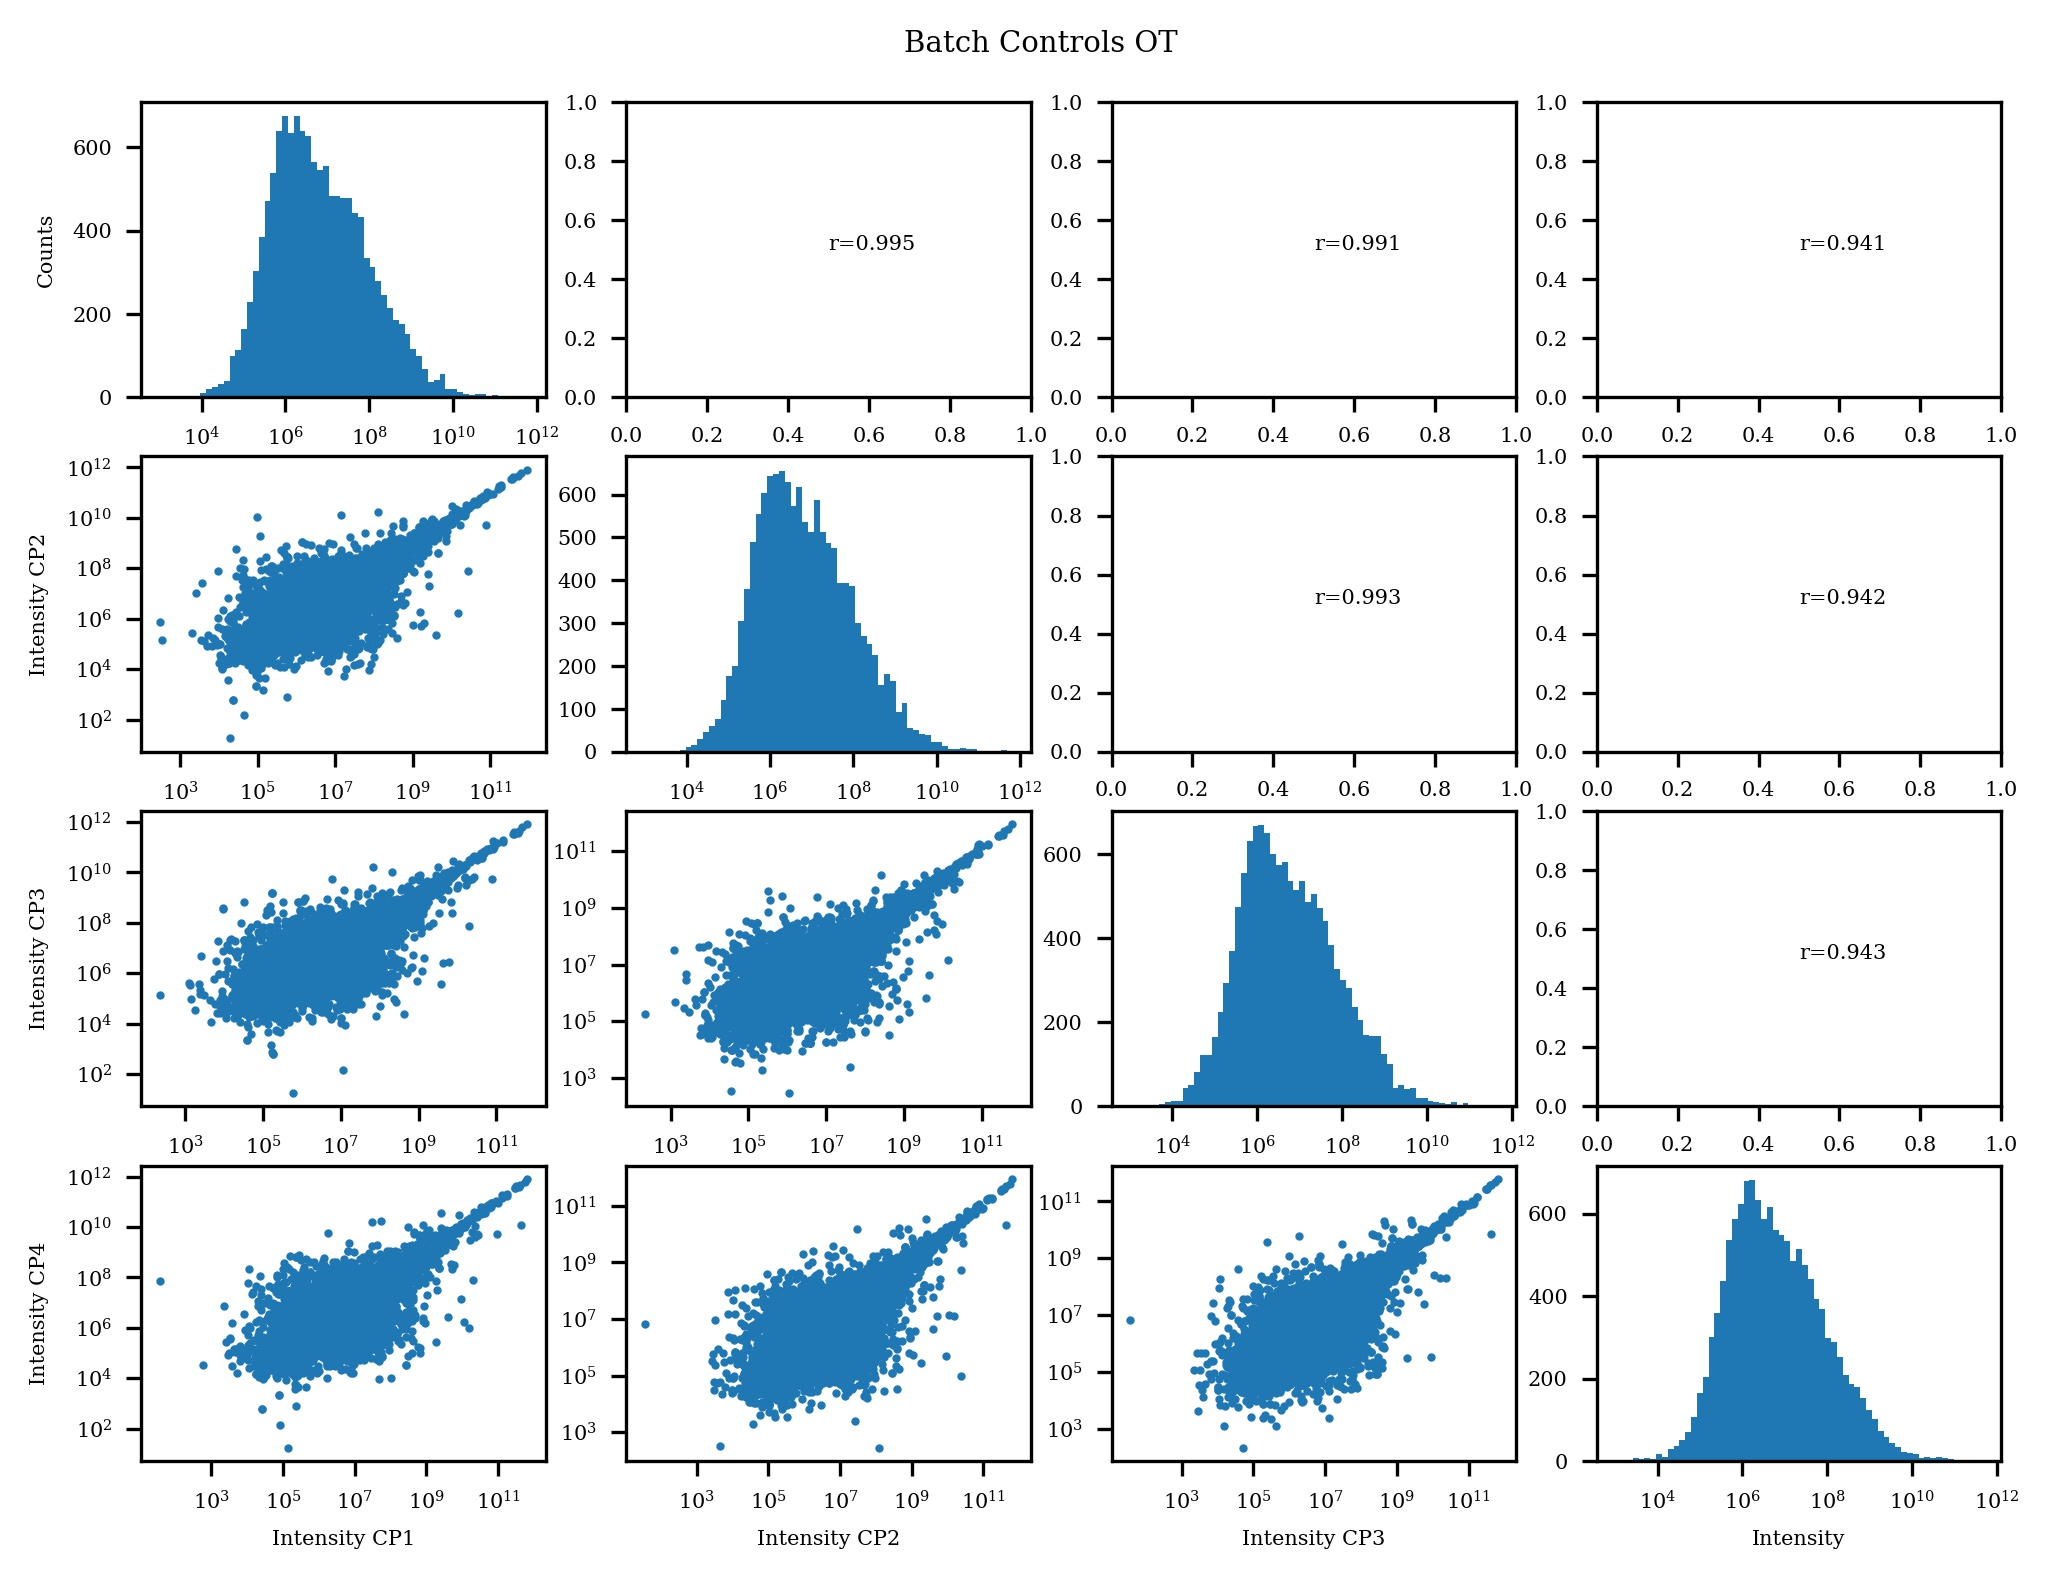

In [195]:
plot_cp_data(data_for_cps[1], title='Batch Controls OT', color=COLORS[0])